In [1]:
import numpy as np
from scipy.integrate import quad
from scipy.special import loggamma, iv
import matplotlib.pyplot as plt


def logiv(nu: float, z: np.ndarray | float) -> np.ndarray:
    z = np.asarray(z)
    log_iv = np.zeros_like(z, dtype=np.float64)

    small_threshold = 1e-2 * (nu + 1)
    large_threshold = 1e+2 * (nu + 1)

    small_z_mask = z < small_threshold
    if np.any(small_z_mask):
        log_iv[small_z_mask] = (
            -loggamma(nu + 1)
            + nu * np.log(z[small_z_mask] / 2)
        )

    large_z_mask = z > large_threshold
    if np.any(large_z_mask):
        log_iv[large_z_mask] = (
            z[large_z_mask] - 0.5 * np.log(2 * np.pi * z[large_z_mask])
        )

    intermediate_z_mask = ~small_z_mask & ~large_z_mask
    if np.any(intermediate_z_mask):
        log_iv[intermediate_z_mask] = np.log(iv(nu, z[intermediate_z_mask]))

    return log_iv


def log_Z(r: np.ndarray | float, T: np.ndarray | float, d: int = 10) -> np.ndarray | float:
    nu = (d - 2) / 2
    return loggamma(d / 2) - (r ** 2 + 1) / (2 * T) + nu * (np.log(2 * T) - np.log(r)) + logiv(nu, r / T)


def U(r: np.ndarray | float, T: np.ndarray | float, d: int = 10) -> np.ndarray | float:
    nu = (d - 2) / 2
    z = r / T
    return 0.5 * (r ** 2 + 1) - r * np.exp(logiv(nu + 1, z) - logiv(nu, z))

def S(r: np.ndarray | float, T: np.ndarray | float, d: int = 10) -> np.ndarray | float:
    return log_Z(r, T, d) + U(r, T, d) / T


def C(r: np.ndarray | float, T: np.ndarray | float, d: int = 10) -> np.ndarray | float:
    nu = (d - 2) / 2
    z = r / T
    iv_frac = np.exp(logiv(nu + 1, z) - logiv(nu, z))
    return z ** 2 * (1 - iv_frac ** 2) - (2 * nu + 1) * z * iv_frac


def logp(r: np.ndarray | float, T: np.ndarray | float, d: int = 10) -> np.ndarray | float:
    nu = (d - 2) / 2
    z = r / T
    return (d / 2) * np.log(r) - (r ** 2 + 1) / (2 * T) - np.log(T) + logiv(nu, z)


def p(r: np.ndarray | float, T: np.ndarray | float, d: int = 10) -> np.ndarray | float:
    return np.exp(logp(r, T, d))
    

In [2]:
d = 10

T_arr = np.logspace(-2.5, 2, 100)
U_arr = []
S_arr = []
C_arr = []

for arr, fun in [(U_arr, U), (S_arr, S), (C_arr, C)]:
    for T in T_arr:
        arr.append(quad(lambda r: p(r, T, d) * fun(r, T, d), 0, 3 * np.sqrt(1 + T))[0])

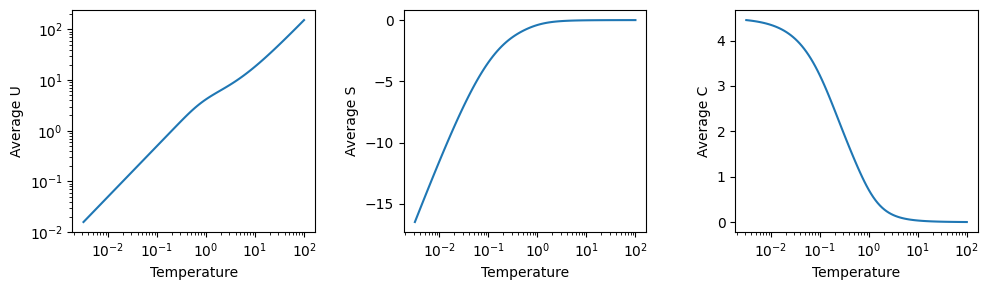

In [5]:
plt.figure(figsize=(10, 3))

for i, (arr, label) in enumerate([(U_arr, "U"), (S_arr, "S"), (C_arr, "C")]):
    plt.subplot(1, 3, i + 1)
    plt.plot(T_arr, arr)
    plt.xlabel("Temperature")
    plt.ylabel(f"Average {label}")
    plt.xscale("log")
    if label in ["U"]:
        plt.yscale("log")

plt.tight_layout()
plt.show()